# Sprint Challenge
## *Data Science Sprint 13*

After a sprint of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. 

## Challenge Objectives
Successfully complete all these objectives to earn full credit. 

**Successful completion is defined as passing all the unit tests in each objective.**  

There are 8 total possible points in this sprint challenge. 


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu. 

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).** 
____

### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy` 
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline` 
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [1]:
# YOUR CODE HERE
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
import gensim
import re

In [2]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [3]:
# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
# YOUR CODE HERE
df = pd.read_json(data_url, lines=True)

In [4]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

In [5]:
df

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA
...,...,...,...,...,...,...,...,...,...
9995,1h3ysSuSazvXc1aeLiiOew,0,2017-10-07 10:57:15,1,kAYnguBAJ2Ovzz5s49fMcQ,1,My family and I were hungry and this Subway is...,1,QFYqAk8n5Z1O3t7zwjA7Hg
9996,Rwahe1zbFpw6VIjb5ngZeg,0,2014-01-18 15:52:52,0,5Huai3nJAaeN8X0vCXqOew,3,My wife and I came here with a a couple of fri...,0,X7jQ-4788irfe5ABZNvYcA
9997,8itGZAOBMiTbHKOwLuh4_Q,0,2018-08-26 02:53:21,0,wmRCto8yNnmMCNc_nfL5Dg,2,The food was just OK and not anything to brag ...,0,_pi5J_1CIQWceLhTJkx_yA
9998,A5Rkh7UymKm0_Rxm9K2PJw,0,2018-04-23 23:36:07,0,zlIU9GEI3MP5LXBpEM5qsw,4,Today's visit is great!! Love and enjoy Town S...,0,PP1K311ZKbpDgTjwic3u5Q


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

**TO PASS CODEGRADE RUNTIME:**
- Do not run your tokenize function more than one time in your notebook! It is not needed until Part 4!

In [6]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

nlp = spacy.load('en_core_web_sm')

In [27]:
# def tokenize(doc):
# # YOUR CODE HERE
#     return [token.lemma_.lower().strip() for token in nlp(doc) if (not token.is_stop) 
#                                                                 and (not token.is_punct)
#                                                                 and (not token.is_digit)
#                                                                 and (not token.like_num)
#                                                                 and (token.lemma_.strip()!="") 
#                                                                 and (len(token.lemma_.strip())>1)]

def tokenize(doc):
    clean_text = re.sub('[^a-zA-Z ]', '', doc)
    return [token.lower() for token in clean_text.split() if len(token) > 2]

In [28]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [9]:
%%time
# YOUR CODE HERE
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.5, min_df=3)
dtm = vect.fit_transform(df['text'])
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names_out())

CPU times: user 625 ms, sys: 166 ms, total: 791 ms
Wall time: 798 ms



2. Write a fake review. Assign the text of the review to an object called `fake_review`. 
3. Query the fake review for the 10 most similar reviews, print the text of the reviews. 
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [10]:
# Create and fit a NearestNeighbors model named "nn"
# YOUR CODE HERE
nn = NearestNeighbors(n_neighbors=10)
nn.fit(dtm)

NearestNeighbors(n_neighbors=10)

In [11]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [12]:
# Create a fake review and find the 10 most similar reviews

# YOUR CODE HERE
fake_review = "great resturant! Loved the juicy burgers. Fried were crispy and delicious"
frt = vect.transform([fake_review])

neigh_dist, neigh_index = nn.kneighbors(frt)
for i in neigh_index:
    print(df['text'][i])

/Users/gregorysamek/anaconda3/envs/U4-S1-NLP/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


6311    天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用...
6204    旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。\n質問にも丁寧...
5294    Great food and great service! Can't wait to go...
3074    Hooray for Simply Burgers!!\n\nIt can be hard ...
7431    Since moving to Mt. Lebanon, this is by far my...
7664    The resturant is small but in a cozy sense, no...
5703    Upon stepping into this resturant, there is no...
9892    Great breakfast at a bargain price!  We both g...
3433    The style of this restaurant is order at the c...
4570    Five big, beautiful, luxuriously juicy stars. ...
Name: text, dtype: object


In [13]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels). 
    - Use that pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 possible values for each parameter
        - **Keep the values for each parameter low. Extreme values will compromise runtime**
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [14]:
# YOUR CODE HERE
clf = KNeighborsClassifier()
pipe = Pipeline([('vect', vect), ('clf', clf)])
parameters = {
    'vect__max_df': (0.25, 0.5),
    'clf__n_neighbors':(5, 10)
}
gs = GridSearchCV(pipe, parameters, cv=3, n_jobs=1, verbose=1)
gs.fit(df['text'], df['stars'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.5, min_df=3,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'clf__n_neighbors': (5, 10),
                         'vect__max_df': (0.25, 0.5)},
             verbose=1)

In [15]:
gs.predict([fake_review])[0]

5

In [16]:
# Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.** 

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz). 

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object. 
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model. 

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

In [17]:
# Do not change this value 
num_topics = 5

In [29]:
# YOUR CODE HERE
df['lemmas'] = df['text'].apply(tokenize)

id2word = corpora.Dictionary(df['lemmas'])
id2word.filter_extremes(no_below=2, no_above=0.5)

corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['lemmas']]

lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

#### Testing

In [30]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'

#### 2. Create 2 visualizations of the results:
1. Create a visualization using pyLDAvis. Run the cell, then comment out your code before submission, leaving the visualization in the cell.

2. Create a visualization using the matplotlib library and utilizing the subplots function. Assign this visualization to a variable called `visual_plot`.


In [42]:
# Cell for pyLDAvis visualization
# YOUR CODE HERE
# import pyLDAvis
# import pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
# vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.020975  0.052453       1        1  24.262735
1      0.059466  0.038907       2        1  23.370713
2      0.068482 -0.058334       3        1  18.150525
0     -0.109957 -0.025500       4        1  17.329094
3      0.002983 -0.007526       5        1  16.886933, topic_info=           Term         Freq        Total Category  logprob  loglift
129        food  4829.000000  4829.000000  Default  30.0000  30.0000
189       great  4229.000000  4229.000000  Default  29.0000  29.0000
344       order  3451.000000  3451.000000  Default  28.0000  28.0000
624        love  2226.000000  2226.000000  Default  27.0000  27.0000
316   delicious  1346.000000  1346.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
315  definitely   300.794846  1418.767759   Topic5  -5.5641   0.2275
417        know   312.484548  1639.524972   Topic5  -5.5260   0.1210
68          get   371.078964  2637.630914   Topic5  -5.3542  -0.1826
392         day   290.005047  1555.056427   Topic5  -5.6007   0.0993
139       price   284.970958  1773.199091   Topic5  -5.6182  -0.0495

[468 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2759      2  0.953181        a.m.
173       1  0.132229  absolutely
173       2  0.081742  absolutely
173       3  0.238012  absolutely
173       4  0.163483  absolutely
...     ...       ...         ...
105       3  0.373400        year
105       4  0.071324        year
105       5  0.238095        year
6995      5  0.928776        yuck
8432      4  0.981308         yuk

[1166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4])

In [31]:
# List of words
target_words = [
    "thai", "curry", "pancake", "store", "buy",
    "car", "pedicure", "nail", "massage",
    "nigiri", "bento", "ramen",
    "vietnamese", "ethiopian", "persian"
]

# Find the indices of the words in the list using id2word
word_indices = [id2word.token2id[word] for word in target_words]

print(word_indices)


[2751, 2562, 2737, 923, 73, 2222, 362, 352, 349, 6966, 2877, 2991, 6030, 2566, 8561]


In [32]:
topic_occ = []
for topic in lda.get_topics():
    topic_occ.append([topic[i] for i in word_indices])

/var/folders/l5/9b73nm7x0d5bz481kpj_k3640000gn/T/ipykernel_35520/1860956138.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(target_words, rotation=45)


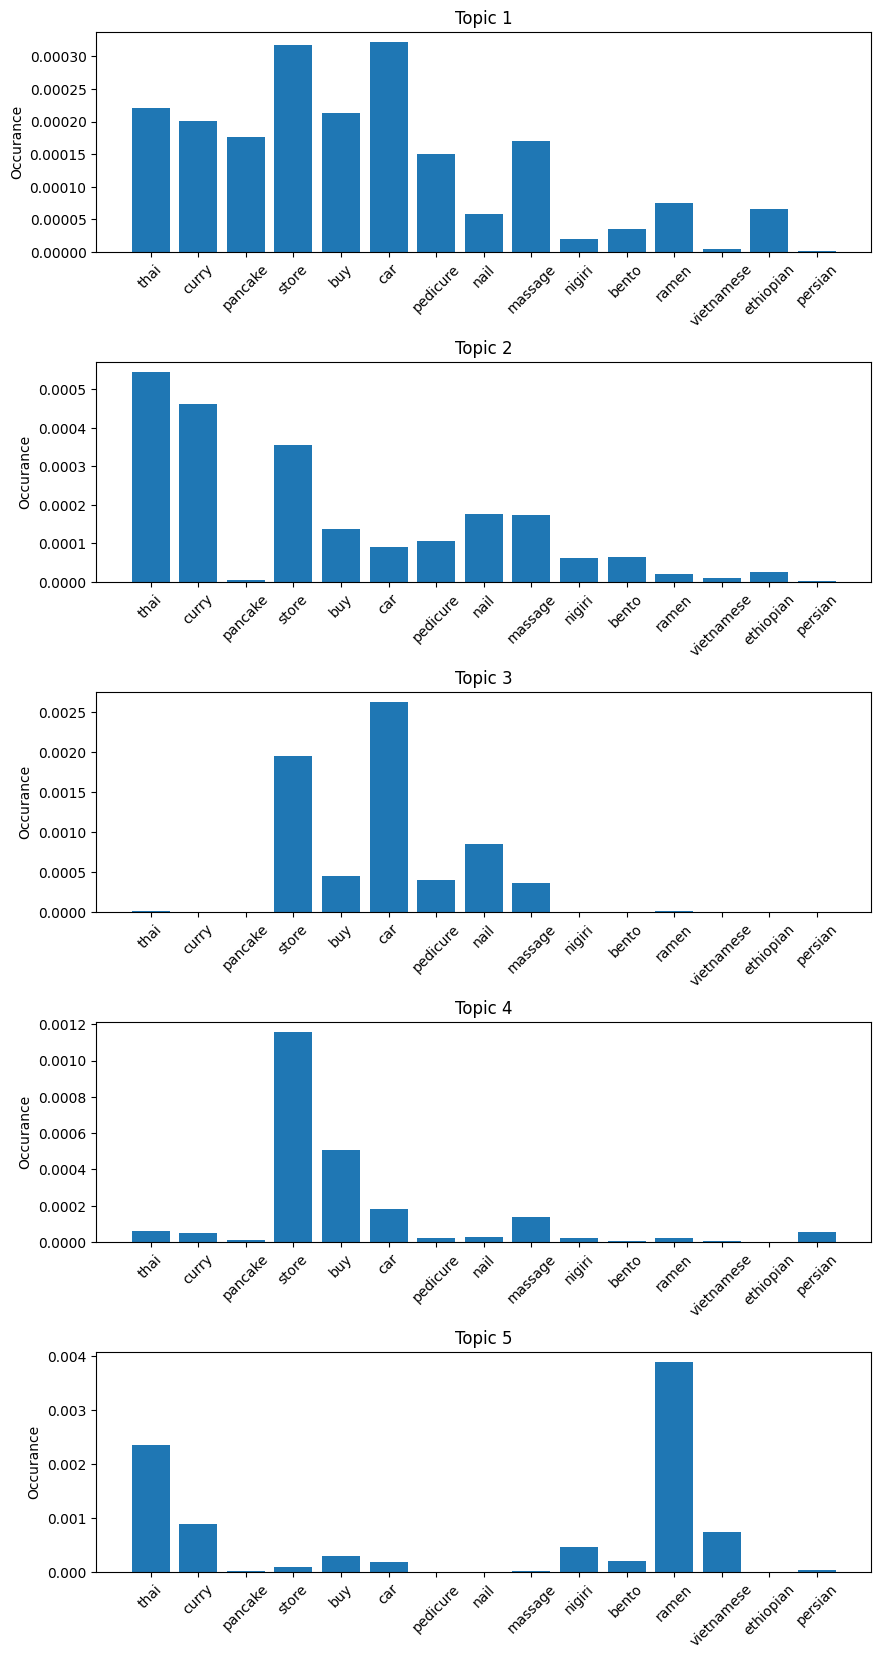

In [33]:
# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)

# Iterate through topic groupings and create bar plots
for i, occ in enumerate(topic_occ):
    ax = axes[i]
    ax.bar(target_words, occ)
    ax.set_title(f"Topic {i+1}")
    ax.set_ylabel("Occurance")
    # ax.set_xlabel("Words")
    ax.set_xticklabels(target_words, rotation=45)

# Show the visualization
plt.show()

# Save the visualization & bypass terrible test that doesn't work
visual_plot = fig
visual_plot.__module__ = 'matplotlib.axes._subplots'


In [23]:
# Visible Testing
assert visual_plot.__module__ == 'matplotlib.axes._subplots', "You must create and assign to visual_plot a visualization"


#### Topics Analysis
Topic one seems to mainly cluster around asian food, especially capturing japanese resturants, and also contains a lot of tokens which appear to be in languages other than english. Topic two seems to cluster around retail / "big box" stores. Topic three appears to cluster around nail salons & spas. Topic four is less focused, and also is positioned in the middle of the other four topics when viewed graphically with LDAvis. It contains niche ethnic resturants. Topic 5 has clustered around topics related to Thai food.